In [ ]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_compilation_cache_dir", "./jax-caches")
# jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
# jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath("."))
sys.path.insert(0, os.path.abspath("."))
sys.path.append(os.path.abspath("../../../"))

# os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.25"
# os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"
# os.environ["XLA_FLAGS"] = (
#     "--xla_disable_hlo_passes=constant_folding "  # this disables constant folding
#     # "--xla_cpu_use_thunk_runtime=false "
# )
from desc import set_device
set_device("gpu")

In [2]:
# import jax
# import jax.numpy as jnp

# jax.config.update("jax_explain_cache_misses", True)

In [3]:
# from desc import set_device, _set_cpu_count

# num_device = 2
# _set_cpu_count(num_device)
# set_device("cpu", num_device=num_device)

In [4]:
import numpy as np
np.set_printoptions(linewidth=np.inf, precision=4, suppress=True, threshold=sys.maxsize)
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
import functools
import scipy

In [7]:
import desc

from desc.basis import *
from desc.backend import *
from desc.compute import *
from desc.coils import *
from desc.equilibrium import *
from desc.examples import *
from desc.grid import *
from desc.geometry import *
from desc.io import *

from desc.objectives import *
from desc.objectives.objective_funs import *
from desc.objectives.getters import *
from desc.objectives.normalization import compute_scaling_factors
from desc.objectives.utils import *
from desc.optimize._constraint_wrappers import *

from desc.transform import Transform
from desc.plotting import *
from desc.optimize import *
from desc.perturbations import *
from desc.profiles import *
from desc.compat import *
from desc.utils import *
from desc.magnetic_fields import *
from desc.particles import *
from diffrax import *

from desc.__main__ import main
from desc.vmec_utils import vmec_boundary_subspace
from desc.input_reader import InputReader
from desc.continuation import solve_continuation_automatic
from desc.compute.data_index import register_compute_fun
from desc.optimize.utils import solve_triangular_regularized

print_backend_info()

DESC version=0.16.0+578.ga5e3fa78f.dirty.
Using JAX backend: jax version=0.6.2, jaxlib version=0.6.2, dtype=float64.
Using device: NVIDIA GeForce RTX 4080 Laptop GPU (id=0), with 11.46 GB available memory.


In [8]:
from desc.plotting import sequential_colors

In [21]:
name = "ncsx"
try:
    # if the file exists, load it
    eq = desc.io.load(f"Optimization/eqs/{name}_vacuum_scaled_solved.h5")
    eqi_scaled = eq.copy()
except:
    # else, create it from scratch
    eqi = get(name)
    eq = rescale(eq=eqi, L=("a", 1.7044), B=("<B>", 5.86), copy=True)
    eq.pressure = 0
    eq.current = 0
    eq.solve(ftol=1e-4, verbose=1)
    eqi_scaled = eq.copy()
    eq.save(f"Optimization/eqs/{name}_vacuum_scaled_solved.h5")
eq.iota = eq.get_profile("iota")

/CODES/DESC/desc/utils.py:572: UserWarning: Setting rotational transform profile on an equilibrium with fixed toroidal current, removing existing toroidal current profile.
  warnings.warn(msg, err)


In [10]:
xis = np.array([0.01, 0.2, 0.5])
rho = 0.4
# xis = 0.5
# rho = 0.4
colors = [
    "#c80016",  # red
    # "#dc5b0e",  # burnt orange
    # "#f0b528",  # light orange
    # "#dce953",  # yellow
    "#0f5c10",  # green
    # "#1fb7c9",  # teal
    # "#2192e3",  # medium blue
    # "#4f66d4",  # blue-violet
    "#9a45db",  # purple
]
particles = ManualParticleInitializerFlux(
    rho0=rho, theta0=0, zeta0=0.0, xi0=xis, E=3.5e6
)
model = VacuumGuidingCenterTrajectory(frame="flux")
ts = np.linspace(0, 7e-5, 2000)

In [54]:
fig = plot_3d(
    eq,
    "|B|",
    alpha=0.2,
    showaxislabels=False,
    showgrid=False,
    zeroline=False,
    showticklabels=False,
    showscale=False,
)
fig, data = plot_particle_trajectories(
    eq,
    model,
    particles,
    ts=ts,
    fig=fig,
    rtol=1e-5, 
    atol=1e-5, 
    min_step_size=1e-8,
    showaxislabels=False,
    showgrid=False,
    zeroline=False,
    showticklabels=False,
    return_data=True,
    color=colors,
)
fig

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 4.

/CODES/DESC/desc/utils.py:572: UserWarning:

Unequal number of field periods for grid 1 and basis 4.



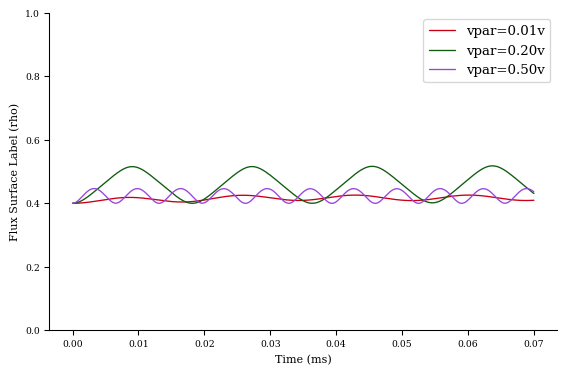

In [55]:
for idx in range(len(data["rho"])):
    plt.plot(
        ts*1000,
        data["rho"][idx],
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v",
    )
plt.xlabel("Time (ms)")
plt.ylabel("Flux Surface Label (rho)")
plt.ylim([0, 1])
plt.legend()
# plt.savefig("rho-time-ncsx.png", dpi=500)

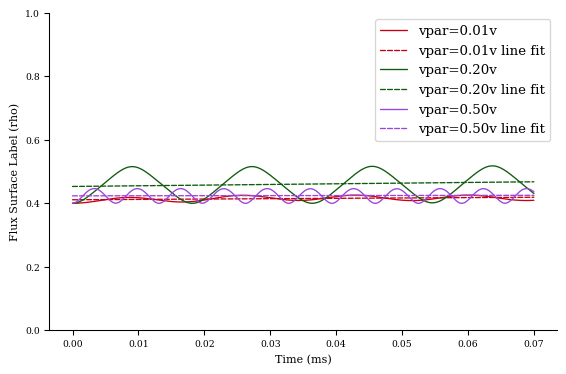

In [56]:
def fit_line(y):
    # replace nans with zeros, since (0,0) is already the initial
    # point, this will not affect the fit
    y = jnp.where(jnp.isnan(y), 0.0, y)
    ts0 = jnp.where(jnp.isnan(y), 0.0, ts)
    coeffs = jnp.polyfit(ts0, y, 1)
    return coeffs

for idx in range(len(data["rho"])):
    plt.plot(
        ts * 1000,
        data["rho"][idx],
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v",
    )
    coeffs = fit_line(data["rho"][idx])
    plt.plot(
        ts * 1000,
        (coeffs[0]*ts + coeffs[1]),
        "--",
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v line fit",
    )
plt.xlabel("Time (ms)")
plt.ylabel("Flux Surface Label (rho)")
plt.ylim([0, 1])
plt.legend()
# plt.savefig("W7-X-particle-line-fit.png", dpi=500)

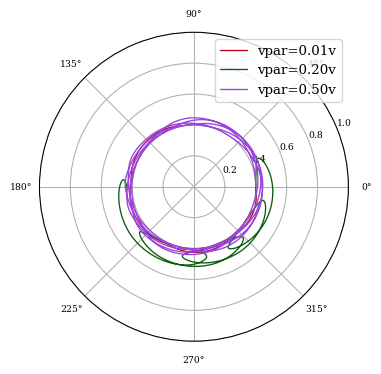

In [57]:
for idx in range(len(data["rho"])):
    plt.polar(
        data["theta"][idx],
        data["rho"][idx],
        color=colors[idx % len(colors)],
        label=f"vpar={xis[idx]:.2f}v",
    )
plt.ylim([0, 1])
plt.legend()
# plt.savefig("ncsx-particle-polar.png", dpi=500)

In [22]:
N = 10  # number of particles traced
RHO0 = [0.3] * N
xi0 = np.linspace(0.1, 0.9, N, endpoint=True)

model = VacuumGuidingCenterTrajectory(frame="flux")
particles = ManualParticleInitializerFlux(
    rho0=RHO0,
    theta0=np.pi/2,
    zeta0=0,
    xi0=xi0,  # add negative region too
    E=3.5e6,
)
x0, model_args = particles.init_particles(model, eq)
interpolator = FourierChebyshevField(L=eq.L_grid, M=eq.M_grid, N=eq.N_grid)
interpolator.build(eq)
interpolator.fit(eq.params_dict, {"iota": eq.iota, "current": eq.current})
stepsize_controller = ConstantStepSize()
ts = np.linspace(0, 1e-4, 1000)
min_step_size = 1e-8
max_steps = int(ts[-1] / min_step_size)
solver = Tsit5()
adjoint = RecursiveCheckpointAdjoint()
def default_event(t, y, args, **kwargs):
    i = jnp.sqrt(y[0] ** 2 + y[1] ** 2)
    return i > 1.0

event = Event(default_event)
particle_chunk_size = None

In [30]:
from desc.particles import _trace_particles
rtz1, _, aux1 = _trace_particles(
    field=eq,
    y0=x0,
    model=model,
    model_args=model_args,
    ts=ts,
    params=eq.params_dict,
    stepsize_controller=PIDController(
        rtol=1e-6,
        atol=1e-6,
        dtmin=min_step_size,
        pcoeff=0.3,
        icoeff=0.3,
        dcoeff=0,
    ),
    saveat=SaveAt(steps=True),
    # saveat=SaveAt(ts=ts),
    max_steps=max_steps,
    min_step_size=min_step_size,
    solver=solver,
    adjoint=adjoint,
    event=event,
    options={},
    chunk_size=particle_chunk_size,
    throw=False,
    return_aux=True,
)

In [31]:
rtz2, _, aux2 = _trace_particles(
    field=interpolator,
    y0=x0,
    model=model,
    model_args=model_args,
    ts=ts,
    params=None,
    stepsize_controller=PIDController(
        rtol=1e-6,
        atol=1e-6,
        dtmin=min_step_size,
        pcoeff=0.3,
        icoeff=0.3,
        dcoeff=0,
    ),
    saveat=SaveAt(steps=True),
    # saveat=SaveAt(ts=ts),
    max_steps=max_steps,
    min_step_size=min_step_size,
    solver=solver,
    adjoint=adjoint,
    event=event,
    options={},
    chunk_size=particle_chunk_size,
    throw=False,
    return_aux=True,
)

In [32]:
rtz3, _, aux3 = _trace_particles(
    field=interpolator,
    y0=x0,
    model=model,
    model_args=model_args,
    ts=ts,
    params=None,
    stepsize_controller=ConstantStepSize(),
    saveat=SaveAt(steps=True),
    # saveat=SaveAt(ts=ts),
    max_steps=max_steps,
    min_step_size=1e-7,
    solver=solver,
    adjoint=adjoint,
    event=event,
    options={},
    chunk_size=particle_chunk_size,
    throw=False,
    return_aux=True,
)

Text(0.5, 1.0, 'xi = 0.2777777777777778')

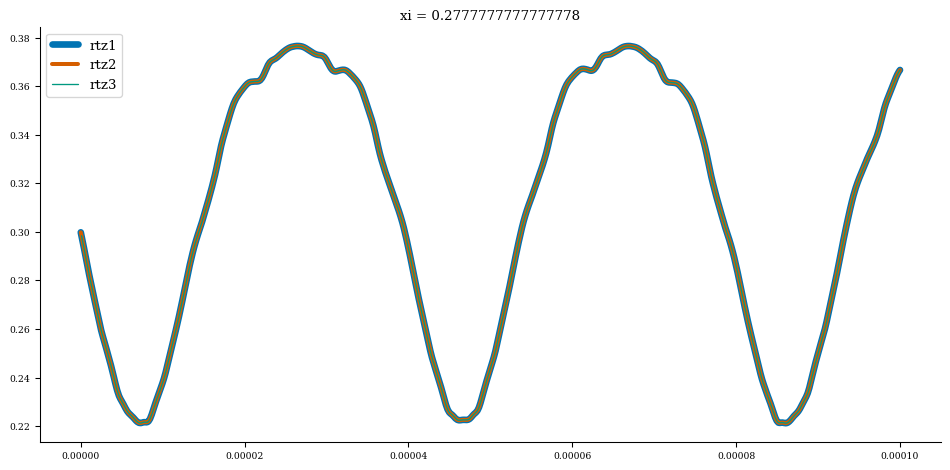

In [40]:
id = 2
plt.figure(figsize=(10, 5))
plt.plot(aux1[0][id], rtz1[id, :, 0], label="rtz1", linewidth=5)
plt.plot(aux2[0][id], rtz2[id, :, 0], label="rtz2", linewidth=3)
plt.plot(aux3[0][id], rtz3[id, :, 0], label="rtz3", linewidth=1)
plt.legend()
plt.title(f"xi = {xi0[id]}")

Text(0.5, 1.0, 'xi = 0.2777777777777778')

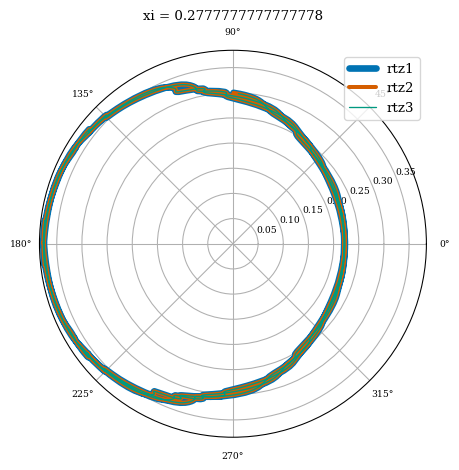

In [41]:
plt.figure(figsize=(10, 5))
plt.polar(rtz1[id, :, 1], rtz1[id, :, 0], label="rtz1", linewidth=5)
plt.polar(rtz2[id, :, 1], rtz2[id, :, 0], label="rtz2", linewidth=3)
plt.polar(rtz3[id, :, 1], rtz3[id, :, 0], label="rtz3", linewidth=1)
plt.legend()
plt.title(f"xi = {xi0[id]}")

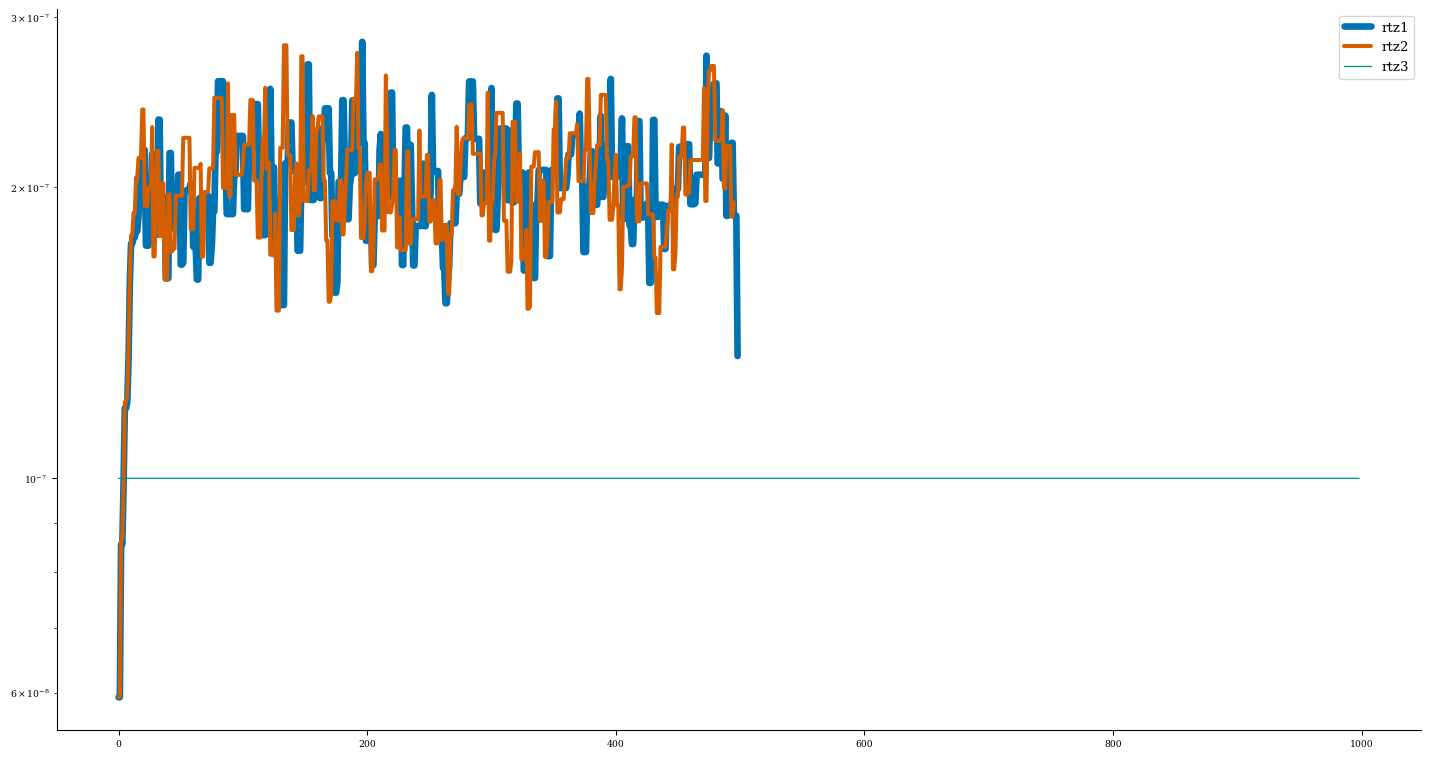

In [42]:
plt.figure(figsize=(15, 8))
plt.semilogy(np.diff(aux1[0][id]), label="rtz1", linewidth=5)
plt.semilogy(np.diff(aux2[0][id]), label="rtz2", linewidth=3)
plt.semilogy(np.diff(aux3[0][id]), label="rtz3", linewidth=1)
plt.legend()

In [43]:
aux1[1], aux2[1], aux3[1]

({'max_steps': Array([10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000], dtype=int64, weak_type=True),
  'num_accepted_steps': Array([411, 413, 500, 586, 662, 715, 772, 828, 904, 961], dtype=int64, weak_type=True),
  'num_rejected_steps': Array([60, 57, 71, 69, 71, 67, 61, 59, 70, 90], dtype=int64, weak_type=True),
  'num_steps': Array([ 471,  470,  571,  655,  733,  782,  833,  887,  974, 1051], dtype=int64, weak_type=True)},
 {'max_steps': Array([10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000], dtype=int64, weak_type=True),
  'num_accepted_steps': Array([409, 413, 497, 587, 653, 716, 778, 824, 904, 962], dtype=int64, weak_type=True),
  'num_rejected_steps': Array([59, 56, 68, 74, 72, 69, 64, 52, 61, 88], dtype=int64, weak_type=True),
  'num_steps': Array([ 468,  469,  565,  661,  725,  785,  842,  876,  965, 1050], dtype=int64, weak_type=True)},
 {'max_steps': Array([10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000], dtype

In [44]:
interpolator.params_dict["coefs_real"][0].shape, interpolator.L, interpolator.M, interpolator.N

((25, 36, 37), 36, 18, 12)

In [45]:
import plotly.graph_objects as go
import numpy as np
import jax.numpy as jnp

# 1. Get the 1D unique axis values
l_vals = interpolator.params_dict["l"]  # Radial (L)
m_vals = interpolator.params_dict["m"]  # Poloidal (M)
n_vals = interpolator.params_dict["n"]  # Toroidal (N)

# 2. Create the 3D grid
# Note: Input order matches the data shape (N, L, M) -> (z, x, y)
# N_grid varies along axis 0 (Toroidal/N)
# L_grid varies along axis 1 (Radial/L)
# M_grid varies along axis 2 (Poloidal/M)
N_grid, L_grid, M_grid = np.meshgrid(n_vals, l_vals, m_vals, indexing="ij")

# 3. Process Coefficients
coeffs = (
    interpolator.params_dict["coefs_real"][0]
    + 1j * interpolator.params_dict["coefs_imag"][0]
)
coeffs = jnp.abs(coeffs)
coeffs_log = jnp.log10(
    coeffs + 1e-16
)  # Use log10 for easier reading of orders of magnitude

# 4. Flatten everything for Plotly
# We map the grids to the desired visual axes:
# Visual X-axis -> Radial (L) -> L_grid
# Visual Y-axis -> Poloidal (M) -> M_grid
# Visual Z-axis -> Toroidal (N) -> N_grid
l_flat = L_grid.flatten()
m_flat = M_grid.flatten()
n_flat = N_grid.flatten()
c_flat = coeffs_log.flatten()

fig = go.Figure(
    data=[
        go.Scatter3d(
            x=l_flat,  # Radial Axis
            y=m_flat,  # Poloidal Axis
            z=n_flat,  # Toroidal Axis
            mode="markers",
            marker=dict(
                size=4,
                color=c_flat,
                colorscale="Turbo",
                opacity=0.8,
                colorbar=dict(title="log10(|C_lmn|)", thickness=20),
            ),
            opacity=0.5,
            hovertemplate=(
                "L (Radial): %{x}<br>"
                + "M (Poloidal): %{y}<br>"
                + "N (Toroidal): %{z}<br>"
                + "Log Magnitude: %{marker.color:.2f}<extra></extra>"
            ),
        )
    ]
)

fig.update_layout(
    title="3D Fourier-Chebyshev Spectrum (B_r)",
    scene=dict(
        xaxis_title="Radial Mode (L)",
        yaxis_title="Poloidal Mode (M)",
        zaxis_title="Toroidal Mode (N)",
        aspectmode="cube",
    ),
    margin=dict(r=0, b=0, l=0, t=40),
    width=1000,
    height=800,
)

fig.show()